In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
np.bool = bool
import seaborn as sns
import run_classical
import ptitprince as pt#seaborn 0.11.0
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import utils
from utils import contaminated_hds

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy import stats
import itertools

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
RESULT_PATH = "final_evaluation/hypermutation/"
CONDITIONS = ["cll_dlbcl_hd", "nlphl_dlbcl_hd", "nlphl_dlbcl_hd_cll"]
SAVE_PLOTS = False
CONDITIONS_DICT = {'cll_dlbcl_hd': 'CLL_DLBCL_HD',
                  'nlphl_dlbcl_hd': 'NLPHL_DLBCL_HD',
                  'nlphl_dlbcl_hd_cll': 'NLPHL_DLBCL_HD_CLL'
                  }

In [3]:
MODELS = ["RandomForest", "LogisticRegression"]

# Load Model Results

In [4]:
df_conditions = pd.DataFrame()
results_conditions_df = pd.DataFrame()
settings_conditions_df = pd.DataFrame()

for condition in CONDITIONS:
    df, results_df, settings_df = utils.load_model_results(RESULT_PATH, condition, MODELS, "F1", weighted_metric=True)
    df["condition"] = condition
    results_df["condition"] = condition
    settings_df["condition"] = condition
    
    df_conditions = pd.concat([df_conditions, df],ignore_index = True)
    results_conditions_df = pd.concat([results_conditions_df, results_df], ignore_index = True)
    settings_conditions_df = pd.concat([settings_conditions_df, settings_df],  ignore_index = True)

## Select best model per n-clones based on validation F1 score for all conditions

In [5]:
best_models_per_clones = []

for condition in CONDITIONS:
    df = df_conditions[df_conditions.condition == condition]
    for i, group in df.groupby("n_clones"):
        group_reg = group[group.model == "LogisticRegression"]
        group_for = group[group.model == "RandomForest"]

        if len(group_reg) != 0:
            best_model_index = np.argmax(group_reg.mean_validation_F1)
            best_models_per_clones.append(group_reg.iloc[best_model_index:best_model_index+1].index[0])
        if len(group_for) != 0:
            best_model_index = np.argmax(group_for.mean_validation_F1)
            best_models_per_clones.append(group_for.iloc[best_model_index:best_model_index+1].index[0])

In [6]:
df_best = df_conditions.loc[best_models_per_clones]
df_best.sort_values(by=["model","condition"], inplace=True, ascending=False)

## Select overall best model per condition

In [7]:
best_models_test_per_condition = {}
best_models_valid_per_condition = {}
best_test_reg_per_condition = {}
best_test_for_per_condition = {}
best_valid_reg_per_condition = {}
best_valid_for_per_condition = {}
for i, condition in enumerate(CONDITIONS):
    df = df_best[df_best.condition == condition]
    if len(df) == 0:
        continue
    best_models_test_per_condition[condition] = list(df.iloc[np.argmax(df.test_F1)][["model", "run", "n_clones"]])
    best_models_valid_per_condition[condition] = list(df.iloc[np.argmax(df.mean_validation_F1)][["model", "run", "n_clones"]])
    
    df_reg = df[df.model == "LogisticRegression"]
    df_for = df[df.model == "RandomForest"]
    
    best_test_reg_per_condition[condition] = list(df_reg.iloc[np.argmax(df_reg.test_F1)][["model", "run", "n_clones"]])
    best_test_for_per_condition[condition] = list(df_for.iloc[np.argmax(df_for.test_F1)][["model", "run", "n_clones"]])
    best_valid_reg_per_condition[condition] = list(df_reg.iloc[np.argmax(df_reg.mean_validation_F1)][["model", "run", "n_clones"]])
    best_valid_for_per_condition[condition] = list(df_for.iloc[np.argmax(df_for.mean_validation_F1)][["model", "run", "n_clones"]])

# Review

In [8]:
path_dir = "data/"
clones_dir = "data/clones_mit_kidera"
comparisons = [['nlphl'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd'], ['cll']]
comparison_labels = ['nlphl', 'dlbcl', 'hd', 'cll']#
class_files, number_of_repertoires = run_classical.load_metadata(comparisons, "IGH", path_dir, clones_dir)

Number of Class 1 repertoires: 90
Number of Class 2 repertoires: 182
Number of Class 3 repertoires: 291
Number of Class 4 repertoires: 348


In [ ]:
df = pd.DataFrame()
for key in class_files.keys():
    for file in class_files[key]:
        df_i = pd.read_csv(file, sep="\t")
        df_i["clones.txt.name"] = os.path.basename(file)
        df = pd.concat([df, df_i])

## nucleotide vs amino acid clonotype definition overlap

In [ ]:
df_nt = df.groupby(["clones.txt.name"])["nSeqCDR3"].unique().apply(len).reset_index()
df_aa = df.groupby(["clones.txt.name"])["aaSeqCDR3"].unique().apply(len).reset_index()

In [ ]:
df_diff = df_nt.merge(df_aa, on = "clones.txt.name")

In [ ]:
df_diff["nSeqCDR3"].sum()

In [ ]:
df_diff["aaSeqCDR3"].sum()

In [ ]:
df_diff["aaSeqCDR3"].sum() / df_diff["nSeqCDR3"].sum()

## correlation of major metrics with sequencing depth 

In [ ]:
df = df[df.aaSeqCDR3.apply(lambda x: not (("_" in x) or ("*" in x)))]

In [ ]:
reads = df.groupby("clones.txt.name")["cloneCount"].sum().reset_index(name='total_reads')
richness = df.groupby("clones.txt.name").apply(lambda x: len(x["aaSeqCDR3"].unique())).reset_index(name='richness')
clonality = df.groupby("clones.txt.name").apply(lambda x: utils.get_clonset_info(x, "clonality")).reset_index(name='clonality')
shannon = df.groupby("clones.txt.name").apply(lambda x: utils.get_clonset_info(x, "shannon")).reset_index(name='shannon')
hypermutation = df.groupby("clones.txt.name").apply(lambda x: utils.get_clonset_info(x, "hypermutation")).reset_index(name='hypermutatedFraction')

In [ ]:
df = df.merge(reads, on = "clones.txt.name")
df = df.merge(richness, on = "clones.txt.name")
df = df.merge(clonality, on = "clones.txt.name")
df = df.merge(shannon, on = "clones.txt.name")
df = df.merge(hypermutation, on = "clones.txt.name")

In [ ]:
from scipy import stats
X = df.groupby("clones.txt.name").first().reset_index()
res = stats.pearsonr(X["total_reads"], X["richness"])
print(res)
res = stats.pearsonr(X["total_reads"], X["clonality"])
print(res)
res = stats.pearsonr(X["total_reads"], X["shannon"])
print(res)

## feature correlation

In [18]:
feature_names = ['cloneFraction', 'lengthOfCDR3', 'clonality', 'shannon', 'richness', 'hypermutatedFraction']  + ['bestVGene', 'bestDGene', 'bestJGene'] + ['KF%i' %i for i in range(1, 11)] 
object_types = ['float64', 'int64', 'float64', 'float64', 'float64', 'float64']  +  ['object', 'object', 'object']+['float64' for i in range(10)] 

In [19]:
X, y, clone_fractions = run_classical.create_features(class_files, 
                                        feature_names, 
                                        object_types, 
                                        20, 
                                        onehot_encoding=True, 
                                        ordinal_encoding=False, 
                                        standardize=True, 
                                        genefamily=False)

<Axes: >

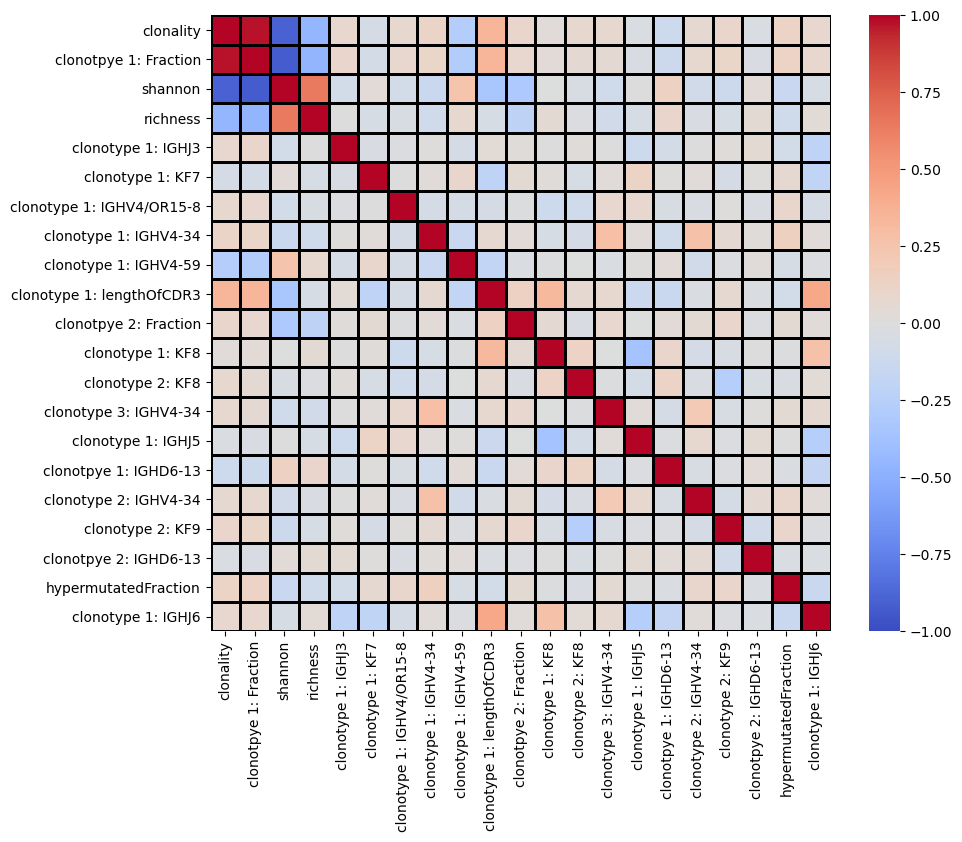

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plotting_df = X[["clonality", "cloneFraction_0", "shannon", "richness",
                 "bestJGene_0_IGHJ3", "KF7_0", "bestVGene_0_IGHV4/OR15-8", "bestVGene_0_IGHV4-34",
                "bestVGene_0_IGHV4-59", "lengthOfCDR3_0", "cloneFraction_1", "KF8_0", "KF8_1",
                "bestVGene_2_IGHV4-34", "bestJGene_0_IGHJ5", "bestDGene_0_IGHD6-13", 
                "bestVGene_1_IGHV4-34", "KF9_1", "bestDGene_1_IGHD6-13", "hypermutatedFraction", "bestJGene_0_IGHJ6"]].copy()


labels = ["clonality", "clonotpye 1: Fraction", "shannon", "richness",
                 "clonotype 1: IGHJ3", "clonotype 1: KF7", "clonotype 1: IGHV4/OR15-8", "clonotype 1: IGHV4-34",
                "clonotype 1: IGHV4-59", "clonotype 1: lengthOfCDR3", "clonotpye 2: Fraction", "clonotype 1: KF8", "clonotype 2: KF8",
                "clonotype 3: IGHV4-34", "clonotype 1: IGHJ5", "clonotpye 1: IGHD6-13", 
                "clonotype 2: IGHV4-34", "clonotype 2: KF9", "clonotpye 2: IGHD6-13", "hypermutatedFraction", "clonotype 1: IGHJ6"]

corr = plotting_df.corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr, ax=ax, vmin=-1, vmax=1, 
            xticklabels = labels, 
            yticklabels=labels,
            cmap = "coolwarm",annot=False, annot_kws={"fontsize":8}, linewidths=1, linecolor='black')

#plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig("feature_correlation.svg", format="svg", bbox_inches='tight')

# Model Performance only top 3 Predictors

In [21]:
model = best_valid_reg_per_condition["nlphl_dlbcl_hd_cll"][0]
run = best_valid_reg_per_condition["nlphl_dlbcl_hd_cll"][1]
path = os.path.join(RESULT_PATH,condition,"outputs_" +model, run, "settings.json")
print(path)

final_evaluation/hypermutation/nlphl_dlbcl_hd_cll/outputs_LogisticRegression/output_Sep_21_124142_9AH8R_classification/settings.json


In [22]:
feature_names = ['cloneFraction', 'shannon', 'clonality']
object_types = ['float64', 'int64', 'float64']

X, y, clone_fractions = run_classical.create_features(class_files, 
                                        feature_names, 
                                        object_types, 
                                        1, 
                                        onehot_encoding=True, 
                                        ordinal_encoding=False, 
                                        standardize=True, 
                                        genefamily=False)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_index, test_index =  sss.split(X, y).__next__()

X_test = X.iloc[test_index]
y_test = y[test_index]
X = X.iloc[train_index]
y = y[train_index]

sampling_strategies = {
    'None': None,
    'adasyn': ADASYN(random_state=42),
    'random_over': RandomOverSampler(random_state=42),
    'smote': SMOTE(random_state=42),
    'random_under' : RandomUnderSampler(random_state=42)
    }

sampler = sampling_strategies["random_over"]


if sampler is not None:
    X, y = sampler.fit_resample(X, y)

model = LogisticRegression(max_iter=100000, penalty="l2", C=1, solver="lbfgs", n_jobs=8)
model.fit(X.values, y)

LogisticRegression(C=1, max_iter=100000, n_jobs=8)

In [23]:
preds = model.predict(X_test.values)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds, target_names=np.asarray(comparison_labels), zero_division=0))

              precision    recall  f1-score   support

       nlphl       0.30      0.33      0.32        18
       dlbcl       0.40      0.32      0.36        37
          hd       0.75      0.83      0.79        58
         cll       0.78      0.77      0.78        70

    accuracy                           0.66       183
   macro avg       0.56      0.56      0.56       183
weighted avg       0.65      0.66      0.65       183



# Top 10 Somatic Hypermutation 

In [25]:
cond_comparison_dict = {
    "cll_dlbcl_hd" : [['cll'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd']],
    "nlphl_dlbcl_hd" : [['nlphl'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd']],
    "nlphl_dlbcl_hd_cll" : [['nlphl'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd'], ["cll"]]
}

In [26]:
comparisons = cond_comparison_dict["nlphl_dlbcl_hd_cll"]

In [27]:
path_dir = "data/"
clones_dir = "data/clones_mit_kidera" 
class_files, number_of_repertoires = run_classical.load_metadata(comparisons, "IGH", path_dir, clones_dir)

Number of Class 1 repertoires: 90
Number of Class 2 repertoires: 182
Number of Class 3 repertoires: 291
Number of Class 4 repertoires: 348


In [28]:
target_lanels = ["NLPHL", "DLBCL", "HD", "CLL"]

In [37]:
df = pd.DataFrame()
for i in range(len(target_lanels)):
    files = class_files[i]
    label = target_lanels[i]
    df_ = utils.read_clones_txt(files, clones_txt_dict= None, normalize_read_count = None,)
    df_["class"] = label
    df = pd.concat([df, df_])

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

In [38]:
topn = 10

In [39]:
df_hyper = []
df_lymph = []
files = []
for i, group in df.groupby("clones.txt.name"):
    group = group.sort_values(by = "cloneId")
    group = group.iloc[:topn]
    #group = group[group['vBestIdentityPercent'].notna()]
    hyper_group = group[group.vBestIdentityPercent < 0.98]
    per = np.sum(hyper_group.cloneFraction)
    df_hyper.append(per)
    df_lymph.append(group["class"].iloc[0])
    files.append(i)

In [40]:
df_hyp = pd.DataFrame({"hyper": df_hyper, "class": df_lymph, "file":files})
df_hyp["hyper"] = df_hyp["hyper"]  * 100
custom_order = ['HD', 'NLPHL', 'DLBCL', 'CLL']
sorting_key = df_hyp['class'].map(lambda x: custom_order.index(x))
df_hyp = df_hyp.iloc[sorting_key.argsort()]

In [41]:
SAVE_PLOTS = False

HD NLPHL
HD DLBCL
HD CLL
NLPHL DLBCL
NLPHL CLL
DLBCL CLL


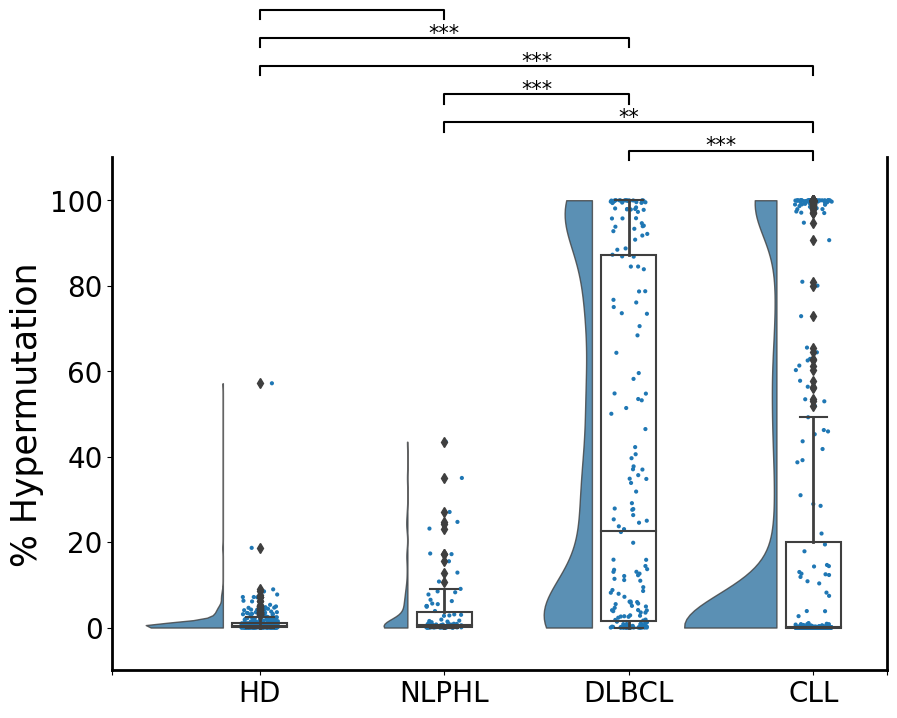

In [42]:
fig, ax = plt.subplots(figsize=(10,6.66))
#sns.violinplot(data=X, x="Class", y="richness", ax=ax, width = 0.9, color="C0", scale="count", cut=0)
pt.RainCloud(x = "class", y = "hyper", data = df_hyp,scale = "count", cut=0,
                     width_viol = 1, width_box=0.3, offset=0.2,ax = ax, pointplot = False, 
             alpha = .8, dodge = True, palette=["C0"])
significant_combinations = []
classes = df_hyp["class"].unique()
class_index_dict  = {}
for i,c in enumerate(classes):
    class_index_dict[c] = i
combinations = itertools.combinations(classes,2)

for i, j in list(combinations):
    print(i,j)
    data1 = df_hyp[df_hyp["class"] == i].hyper
    data2 = df_hyp[df_hyp["class"] == j].hyper
    
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    #if p < 0.05:
    significant_combinations.append([(i,j), p])
      
bottom, top = ax.get_ylim()
y_range = top - bottom
# Significance bars
for i, significant_combination in enumerate(significant_combinations):   
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.06 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1.5, c='k',clip_on=False
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    text_height = bar_height*0.99
    plt.text((class_index_dict[x1] + class_index_dict[x2]) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=15)

yticks = []
for tick in ax.get_yticklabels():
    tick_text = tick.get_text()
    tick_number = float(tick.get_text().replace('−', '-'))
    if tick_number >100:
        yticks.append("")
    else:
        yticks.append(tick_text)
ax.set_xticks([-0.8, 0, 1, 2, 3, 3.4])
ax.set_yticklabels(list(yticks))
    
ax.set_ylim(0-100*0.1,100 + 100 * 0.1)
ax.spines[['top']].set_visible(False)
ax.spines[['right', 'bottom','left']].set_linewidth(2)
ax.tick_params(axis='both', labelsize=20)
ax.set_ylabel("% Hypermutation",fontsize=25)
ax.set_xlabel("", fontsize=18)
#ax.set_yscale('log')

if SAVE_PLOTS:
    #plt.savefig('hypermutation.svg', format="svg", bbox_inches='tight')
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig("topn_hypermutation.svg", format="svg", bbox_inches="tight")

## Data Origin

In [29]:
comparison_labels = ['NLPBL', 'DLBCL', 'HD', 'CLL']

In [30]:
data_files = {}
for i in class_files.keys():
    data_files[comparison_labels[i]] = [x.split("/")[-1] for x in class_files[i]]

In [31]:
xl_meta_file = pd.ExcelFile("/Users/labadmin/Projects/NEU_Zuordnungen_mitMIAIRR_29.02.2024.xlsx")
xl_dfs = {s: xl_meta_file.parse(s) for s in xl_meta_file.sheet_names}
db = xl_dfs["Zuordnungen_mitMIAIRR"]
db.dropna(axis=1, how='all', inplace=True)

In [32]:
data_table = pd.DataFrame()
for key in data_files.keys():
    df_i = db[db["clones.txt.name"].isin(data_files[key])].copy()
    df_i.sort_values(by = "subject_id")
    df_i = df_i[["clones.txt.name", "subject_id", "tissue"]]
    df_i["cohort"] = key
    data_table = pd.concat([data_table, df_i])

In [33]:
df = pd.DataFrame()
for key in class_files.keys():
    for file in class_files[key]:
        df_i = pd.read_csv(file, sep="\t")
        df_i["clones.txt.name"] = os.path.basename(file)
        df = pd.concat([df, df_i])

In [34]:
reads = df.groupby("clones.txt.name")["cloneCount"].sum().reset_index(name='total_reads')
richness = df.groupby("clones.txt.name").apply(lambda x: len(x["aaSeqCDR3"].unique())).reset_index(name='richness')
clonality = df.groupby("clones.txt.name").apply(lambda x: utils.get_clonset_info(x, "clonality")).reset_index(name='clonality')
shannon = df.groupby("clones.txt.name").apply(lambda x: utils.get_clonset_info(x, "shannon")).reset_index(name='shannon')
hypermutation = df.groupby("clones.txt.name").apply(lambda x: utils.get_clonset_info(x, "hypermutation")).reset_index(name='hypermutatedFraction')

In [35]:
df = df.merge(reads, on = "clones.txt.name")
df = df.merge(richness, on = "clones.txt.name")
df = df.merge(clonality, on = "clones.txt.name")
df = df.merge(shannon, on = "clones.txt.name")
df = df.merge(hypermutation, on = "clones.txt.name")

In [36]:
data_metric_info = df.groupby("clones.txt.name").first().reset_index()

In [37]:
data_metric_info.columns

Index(['clones.txt.name', 'cloneId', 'cloneCount', 'cloneFraction', 'nSeqCDR3',
       'aaSeqCDR3', 'bestVGene', 'bestDGene', 'bestJGene',
       'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences', 'allVGenes',
       'allDGenes', 'allJGenes', 'allVHits', 'allDHits', 'allJHits',
       'allVAlignments', 'allDAlignments', 'allJAlignments', 'KF1', 'KF2',
       'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8', 'KF9', 'KF10',
       'dBestIdentityPercent', 'jBestIdentityPercent', 'aaSeqCDR2',
       'aaSeqCDR1', 'aaSeqFR2', 'aaSeqFR3', 'aaSeqFR4',
       'aaSeqImputedVDJRegion', 'total_reads', 'richness', 'clonality',
       'shannon', 'hypermutatedFraction'],
      dtype='object')

In [38]:
data_metric_info[["clones.txt.name", "total_reads", "richness", "clonality", "shannon", "hypermutatedFraction"]]

,clones.txt.name,total_reads,richness,clonality,shannon,hypermutatedFraction
0,101-D0-Ig-gDNA-PB-Nuray-A250_S240.clones.txt,40599,195,0.081108,6.990317,0.086102
1,101-D28-Ig-gDNA-PB-Nuray-A250_S190.clones.txt,39073,4030,0.043305,11.457920,0.193221
2,105-D0-Ig-gDNA-PB-Nuray-A250_S179.clones.txt,99392,2619,0.049125,10.796991,0.197785
3,105-D14-Ig-gDNA-human-Nuray_S59.clones.txt,19236,3636,0.028911,11.486175,0.151463
4,105-D7-Ig-gDNA-human-Nuray_S58.clones.txt,18515,237,0.072602,7.316003,0.198312
...,...,...,...,...,...,...
906,Simon-Ig-CLL-I3P_S200.clones.txt,63622,14,0.752524,0.942228,0.000031
907,Svenja-IGH-HD121-28-10-2020_S161.clones.txt,142435,2213,0.038640,10.682427,0.218488
908,Svenja-IGH-HD128_S162.clones.txt,53739,1604,0.038696,10.235439,0.538559
909,Svenja-IGH-HD129_S163.clones.txt,94323,2771,0.034550,11.041065,0.301457


In [39]:
data_table = data_table.merge(data_metric_info[["clones.txt.name", "total_reads", "richness", "clonality", "shannon", "hypermutatedFraction"]], on = "clones.txt.name")

### 29. NLPBL cases 

In [40]:
xl_meta_file = pd.ExcelFile("/Volumes/tuim$/TUIM/shared/UKH_Ordner/LisaS/X_abgeschlossene_Projekte/NLPHL/Samples_NLPHL.xlsx")
xl_dfs = {s: xl_meta_file.parse(s) for s in xl_meta_file.sheet_names}
used_nlpbl_samples = xl_dfs["Tabelle1"]
used_nlpbl_samples.dropna(axis=1, how='all', inplace=True)
used_nlpbl_samples.columns = list(used_nlpbl_samples.iloc[1])
used_nlpbl_samples = used_nlpbl_samples.iloc[2:]

In [41]:
used_nlpbl_samples_files = used_nlpbl_samples.Dateiname.dropna()
used_nlpbl_samples_files = list(used_nlpbl_samples_files[used_nlpbl_samples_files.apply(lambda x: "_hs_" in str(x))])

In [42]:
paper_occurance = []
found_samples = 0
for i,file in enumerate(data_table["clones.txt.name"]):
    file = file.replace("-", "_")
    papers = [] 
    for j in used_nlpbl_samples_files:
        j_ = j.replace("-", "_")
        if j_ in file:
            used_nlpbl_samples_files.remove(j)
            found_samples += 1
            papers.append(29)
            break

    paper_occurance.append(str(papers))

In [43]:
data_table["papers"] = paper_occurance

In [ ]:
data_table.loc[data_table.subject_id.isin(data_table[data_table.papers == "[29]"].subject_id), "papers"] = "[29]"

### 37. Loewenkids paper

In [44]:
xl_meta_file = pd.ExcelFile("/Volumes/tuim$/TUIM/shared/UKH_Ordner/LisaS/LoewenKids/Altersgruppen/Kontrollkohorte-reine-HDs/immundb_igh_HD.xlsx")
xl_dfs = {s: xl_meta_file.parse(s) for s in xl_meta_file.sheet_names}
loewen_df = xl_dfs["Sheet 1"]
loewen_df.dropna(axis=1, how='all', inplace=True)

In [45]:
for i,row in data_table[data_table["clones.txt.name"].isin(loewen_df["clones.txt.name"])].iterrows():
    data_table.loc[i, "papers"] = str(eval(data_table.loc[i, "papers"]) + [37])

### 38. HACO and DigiHero

In [51]:
"/Volumes/tuim$/TUIM/Christoph/1_Projects/COVID-19/10 - DigiHero/2_Booster_hybrid_immunity/BNT_MOD_CoV2_Impfung_2020.xlsx"

'/Volumes/tuim$/TUIM/Christoph/1_Projects/COVID-19/10 - DigiHero/2_Booster_hybrid_immunity/BNT_MOD_CoV2_Impfung_2020.xlsx'

In [55]:
booster_samples = db[db["clones.txt.name"].apply(lambda x: "bnt" in x.lower() if not pd.isna(x) else False)]
haco_samples = db[db["clones.txt.name"].apply(lambda x: "haco" in x.lower() if not pd.isna(x) else False)]

In [58]:
covid_samples = list(booster_samples["clones.txt.name"]) + list(haco_samples["clones.txt.name"])

In [59]:
for i,row in data_table[data_table["clones.txt.name"].isin(covid_samples)].iterrows():
    data_table.loc[i, "papers"] = str(eval(data_table.loc[i, "papers"]) + [38])

### 39. CLL

In [69]:
xl_meta_file = pd.ExcelFile("/Volumes/tuim$/TUIM/shared/UKH_Ordner/LisaS/X_abgeschlossene_Projekte/CLL_R110_clonal_evolution/Pat_Listen/CLL_cohort_überischt_katrin_n167.xlsx")
xl_dfs = {s: xl_meta_file.parse(s) for s in xl_meta_file.sheet_names}
used_cll_samples = xl_dfs["unique CLL"]

In [74]:
cll_samples_ids = list(used_cll_samples["Unique identifier"].dropna())

In [76]:
for i,row in data_table[data_table["subject_id"].isin(cll_samples_ids)].iterrows():
    data_table.loc[i, "papers"] = str(eval(data_table.loc[i, "papers"]) + [39])

### 40. Rearrangements by Covid19

In [79]:
"/Volumes/tuim$/TUIM/shared/UKH_Ordner/LisaS/X_abgeschlossene_Projekte/COVID19_2_BCR_JCI/Kohorten"

'/Volumes/tuim$/TUIM/shared/UKH_Ordner/LisaS/X_abgeschlossene_Projekte/COVID19_2_BCR_JCI/Kohorten'

In [80]:
covid_study_samples = pd.read_csv("covid_study_samples.csv")

In [81]:
for i,row in data_table[data_table["clones.txt.name"].isin(covid_study_samples["clones.txt.name"].unique())].iterrows():
    data_table.loc[i, "papers"] = str(eval(data_table.loc[i, "papers"]) + [40])

In [96]:
xl_meta_file = pd.ExcelFile("/Volumes/tuim$/TUIM/shared/UKH_Ordner/LisaS/X_abgeschlossene_Projekte/COVID19_2_BCR_JCI/Kohorten/norm-Cancer-solid.xlsx")
xl_dfs = {s: xl_meta_file.parse(s) for s in xl_meta_file.sheet_names}
used_solid_samples = xl_dfs["Tabelle1"]

In [102]:
xl_meta_file = pd.ExcelFile("/Volumes/tuim$/TUIM/shared/UKH_Ordner/LisaS/X_abgeschlossene_Projekte/COVID19_2_BCR_JCI/Kohorten/norm-Cancer-blood.xlsx")
xl_dfs = {s: xl_meta_file.parse(s) for s in xl_meta_file.sheet_names}
used_blood_samples = xl_dfs["Tabelle1"]

In [104]:
data_table[data_table["clones.txt.name"].isin(used_blood_samples["filename"])]

array(['CLL'], dtype=object)

### 41. NGS T and B HD cohort

In [90]:
"/Volumes/tuim$/TUIM/Christoph/1_Projects/COVID-19/1 - Manuscript"

'/Volumes/tuim$/TUIM/Christoph/1_Projects/COVID-19/1 - Manuscript'

In [93]:
hd_subjects = [f"HD00{x+1}" if x+1 < 10 else f"HD0{x+1}" for x in range(39)]

In [103]:
for i,row in data_table[data_table.subject_id.apply(lambda x: x.replace("-","") in hd_subjects if not pd.isna(x) else False)].iterrows():
    data_table.loc[i, "papers"] = str(eval(data_table.loc[i, "papers"]) + [41])

### 42.  Maturation Trajectories

In [ ]:
"10 healthy individuals vaccinated with the seasonal influenza vaccine"

In [123]:
vacc_hds = ["HD003", "HD79", "HD91", "HD125", "HD154", "HD155"]

In [134]:
vacc_hds

['HD003', 'HD79', 'HD91', 'HD125', 'HD154', 'HD155']

In [136]:
#vacc_hd_samples = db[(db.subject_id.isin(vacc_hds)) & (db.run_id == "ML127_2_Binder21_210129")]
vacc_hd_samples = db[(db.subject_id.isin(vacc_hds))]

In [138]:
for i,row in data_table[data_table["clones.txt.name"].isin(vacc_hd_samples["clones.txt.name"].unique())].iterrows():
    data_table.loc[i, "papers"] = str(eval(data_table.loc[i, "papers"]) + [42])

### 43. SLAMF receptors 

In [ ]:
possible_run_ids = ['151207_M04267_0001_000000000-AKNDT',
       '160210_M04267_0002_000000000-AMDP1',
       '160322_M04267_0003_000000000-ALHW9',
       '160513_M04267_0004_000000000-ANUR2',
       '160614_M04267_0005_000000000-APPCB',
       '160901_M04267_0006_000000000-ARKY1',
       '161213_M04267_0008_000000000-AY7FN',
       '170224_M04267_0010_000000000-B467K',
       '170330_M04267_0012_000000000-B4C99',
       '170615_M04267_0015_000000000-B5BM3',
       '170720_M04267_0016_000000000-B832Y',
       '170908_M04267_0018_000000000-BBN75',
       '171019_M04267_0019_000000000-BD5JH',
       '171208_M04267_0021_000000000-BFJW8',
       '180201_M04267_0023_000000000-BGTD4',
       '180626_M04267_0028_000000000-BPR2V', 'ML90_Binder2_190208', 'ML91_Binder3_190325',"ML95_Binder4_190510", 
       'ML99_Binder5_190708', 'ML100_Binder6_190719','ML103_Binder7_190920', 'ML106_Binder8_191112', 'ML107_Binder9_191219',
       'ML108_Binder10_200220']

In [ ]:
possible_cll_files = db[(db.disease_diagnosis == "cll") & (db.run_id.isin(possible_run_ids)) & (db.pcr_target_locus == "IGH")
  & (db.study_title == "cll")]

In [ ]:
for i,row in data_table[data_table["clones.txt.name"].isin(possible_cll_files["clones.txt.name"].unique())].iterrows():
    data_table.loc[i, "papers"] = str(eval(data_table.loc[i, "papers"]) + [43])

### 44. T-cell architecture in autoimmune  hepatitis. HDs

In [ ]:
hds = pd.read_csv("/Volumes/tuim$/TUIM/Christoph/1_Projects/AIH/clones-txt/hd_igh_all.csv",header=None)

In [ ]:
for i,row in data_table[data_table["clones.txt.name"].isin(hds[0].unique())].iterrows():
    data_table.loc[i, "papers"] = str(eval(data_table.loc[i, "papers"]) + [44])

### 45. autoimmune cytopenias

In [ ]:
hds_clls = pd.read_csv("filereport_read_run_PRJEB33806_tsv.txt", sep = "\t")

In [ ]:
data_table[data_table.subject_id.isin(hds_clls.sample_alias)]

In [ ]:
for i,row in data_table[data_table.subject_id.isin(hds_clls.sample_alias)].iterrows():
    data_table.loc[i, "papers"] = str(eval(data_table.loc[i, "papers"]) + [44])

In [ ]:
possible_run_ids = ['151207_M04267_0001_000000000-AKNDT',
       '160210_M04267_0002_000000000-AMDP1',
       '160322_M04267_0003_000000000-ALHW9',
       '160513_M04267_0004_000000000-ANUR2',
       '160614_M04267_0005_000000000-APPCB',
       '160901_M04267_0006_000000000-ARKY1',
       '161213_M04267_0008_000000000-AY7FN',
       '170224_M04267_0010_000000000-B467K',
       '170330_M04267_0012_000000000-B4C99',
       '170615_M04267_0015_000000000-B5BM3',
       '170720_M04267_0016_000000000-B832Y',
       '170908_M04267_0018_000000000-BBN75',
       '171019_M04267_0019_000000000-BD5JH',
       '171208_M04267_0021_000000000-BFJW8',
       '180201_M04267_0023_000000000-BGTD4',
       '180626_M04267_0028_000000000-BPR2V', 'ML90_Binder2_190208', 'ML91_Binder3_190325',"ML95_Binder4_190510", 
       'ML99_Binder5_190708', 'ML100_Binder6_190719']

In [ ]:
possible_files = db[(db.run_id.isin(possible_run_ids)) & (db.pcr_target_locus == "IGH")]

In [ ]:
hds = possible_files[possible_files.disease_diagnosis == "hd"]
hds = hds[hds.subject_id.apply(lambda x: "HD" in x if not pd.isna(x) else False)]

In [ ]:
for i,row in data_table[data_table["clones.txt.name"].isin(hds["clones.txt.name"].unique())].iloc[:43].iterrows():
    data_table.loc[i, "papers"] = str(eval(data_table.loc[i, "papers"]) + [45])

In [ ]:
clls = possible_files[possible_files.subject_id.apply(lambda x: "cll" in x.lower() if not pd.isna(x) else False)]

In [ ]:
for i,row in data_table[data_table["clones.txt.name"].isin(clls["clones.txt.name"].unique())].iloc[:12].iterrows():
    data_table.loc[i, "papers"] = str(eval(data_table.loc[i, "papers"]) + [45])

### 46.  Differential organization of tonic and chronic B cell antigen receptors

### ???

### 47. The phosphotyrosine phosphatase SHP2 promotes anergy in chronic lymphocytic leukemia

In [ ]:
possible_run_ids = ['151207_M04267_0001_000000000-AKNDT',
       '160210_M04267_0002_000000000-AMDP1',
       '160322_M04267_0003_000000000-ALHW9',
       '160513_M04267_0004_000000000-ANUR2',
       '160614_M04267_0005_000000000-APPCB',
       '160901_M04267_0006_000000000-ARKY1',
       '161213_M04267_0008_000000000-AY7FN',
       '170224_M04267_0010_000000000-B467K',
       '170330_M04267_0012_000000000-B4C99',
       '170615_M04267_0015_000000000-B5BM3',
       '170720_M04267_0016_000000000-B832Y',
       '170908_M04267_0018_000000000-BBN75',
       '171019_M04267_0019_000000000-BD5JH',
       '171208_M04267_0021_000000000-BFJW8',
       '180201_M04267_0023_000000000-BGTD4',]

In [ ]:
possible_files = db[(db.run_id.isin(possible_run_ids)) & (db.pcr_target_locus == "IGH")]

In [ ]:
possible_files[possible_files.disease_diagnosis.isin(["cll"])].subject_id.unique()

In [ ]:
clls = possible_files[possible_files.subject_id.apply(lambda x: "cll" in x.lower() if not pd.isna(x) else False)]

In [ ]:
for i,row in data_table[data_table["clones.txt.name"].isin(clls["clones.txt.name"].unique())].iloc[:74].iterrows():
    data_table.loc[i, "papers"] = str(eval(data_table.loc[i, "papers"]) + [47])

### 48. Dynamic changes of the normal B lymphocyte repertoire in CLL in response to ibrutinib or FCR chemo-immunotherapy

In [ ]:
"/Users/labadmin/Projects/immusign/koni-07-04-1417720-s001/2017ONCOIMM0618R-s01.pdf"

In [ ]:
possible_run_ids = ['151207_M04267_0001_000000000-AKNDT',
       '160210_M04267_0002_000000000-AMDP1',
       '160322_M04267_0003_000000000-ALHW9',
       '160513_M04267_0004_000000000-ANUR2',
       '160614_M04267_0005_000000000-APPCB',
       '160901_M04267_0006_000000000-ARKY1',
       '161213_M04267_0008_000000000-AY7FN',
       '170224_M04267_0010_000000000-B467K',
       '170330_M04267_0012_000000000-B4C99',
       '170615_M04267_0015_000000000-B5BM3',
       '170720_M04267_0016_000000000-B832Y',
       '170908_M04267_0018_000000000-BBN75',
       '171019_M04267_0019_000000000-BD5JH',
       '171208_M04267_0021_000000000-BFJW8',
       '180201_M04267_0023_000000000-BGTD4',]

In [ ]:
possible_files = db[(db.run_id.isin(possible_run_ids)) & (db.pcr_target_locus == "IGH")]

In [ ]:
hds = ["HD036","HD037","HD039","HD051","HD052","HD074","HD075","HD076", "HD077"]
clls = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9','F10'] + ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10']

samples = hds + clls

In [ ]:
df_i = data_table[data_table.subject_id.isin(samples)].copy()
df_i["index"] = list(df_i.index)
df_i = df_i.groupby("subject_id").first().reset_index()
df_i.index = list(df_i["index"])

In [ ]:
for i,row in df_i.iterrows():
    data_table.loc[i, "papers"] = str(eval(data_table.loc[i, "papers"]) + [48])

### 49.  Clinical response to ibrutinib is accompanied by normalization of the T-cell environment in CLL-related autoimmune cytopenia

In [ ]:
possible_run_ids = ['151207_M04267_0001_000000000-AKNDT',
       '160210_M04267_0002_000000000-AMDP1',
       '160322_M04267_0003_000000000-ALHW9']

In [ ]:
possible_files = db[(db.run_id.isin(possible_run_ids)) & (db.pcr_target_locus == "IGH")]

In [ ]:
clls = possible_files[possible_files.disease_diagnosis.apply(lambda x: "cll" in x)]

In [ ]:
for i,row in data_table[data_table["clones.txt.name"].isin(clls["clones.txt.name"].unique())].iterrows():
    data_table.loc[i, "papers"] = str(eval(data_table.loc[i, "papers"]) + [49])

In [ ]:
df_missing = data_table[data_table.papers == "[]"]
df_found = data_table[data_table.papers != "[]"]

In [ ]:
df_replace = df_found[df_found.subject_id.isin(df_missing.subject_id)].groupby("subject_id").first()

In [ ]:
df_missing[df_missing.subject_id == "HD079"]

In [ ]:
for i, row in df_replace.iterrows():
    data_table.loc[(data_table.papers == "[]") & (data_table.subject_id == i), "papers"] = row.papers

In [ ]:
#data_table.to_csv("data_table.csv", index=False)

In [ ]:
data_table = pd.read_csv("/Volumes/tuim$/TUIM/Paul/Anträge/immusign/data_table.csv")

In [ ]:
len(data_table[data_table.cohort == "DLBCL"]["subjects"].unique())

In [ ]:
len(data_table[data_table.cohort == "HD"]["subjects"].unique())

In [ ]:
len(data_table[data_table.cohort == "CLL"]["subjects"].unique())

In [ ]:
len(data_table[data_table.cohort == "NLPBL"]["subjects"].unique())

## Data Table 

In [86]:
data_table = pd.read_csv("/Volumes/tuim$/TUIM/Paul/Anträge/immusign/data_table.csv")

In [87]:
data_table.groupby("cohort")["subjects"].unique().apply(len)

cohort
CLL      196
DLBCL    163
HD       176
NLPBL     43
Name: subjects, dtype: int64

In [88]:
data_table.drop(columns = ["subject_id"], inplace = True)

In [89]:
grouped = data_table.groupby(["cohort", "subjects"]).size().reset_index()


def reset_index_per_group(group):
    return group.reset_index(drop=True)

grouped = grouped.groupby(['cohort']).apply(reset_index_per_group)
grouped = grouped.droplevel(0)
grouped["index"] = list(grouped.index)
grouped["subject_id"] = grouped["cohort"] + (grouped["index"] + 1).apply(str)

In [90]:
data_table = data_table.merge(grouped[["cohort", "subjects", "subject_id"]], on = ["cohort", "subjects"])

In [91]:
data_table

,clones.txt.name,sample_id,tissue,cohort,total_reads,richness,clonality,shannon,hypermutatedFraction,references,subjects,time_point,subject_id_old,subject_id
0,Dona-hs-FR3IGH-5100-13-Tumor-Rezidiv-gDNA_S220...,NLPBL1,ln,NLPBL,75666,5137,0.044914,11.773070,0.247818,[29],NLPHL02,Rez,NLPHL02_Rez,NLPBL3
1,Dona-hs-FR3IGH-H16768-12-Tumor-Erstdiagnose-gD...,NLPBL4,ln,NLPBL,29755,6278,0.028764,12.253196,0.199273,[29],NLPHL02,ED,NLPHL02_ED,NLPBL3
2,Dona-hs-FR3IGH-15504-12-Tumor-Rezidiv2-gDNA_S2...,NLPBL2,ln,NLPBL,88194,7416,0.044320,12.286624,0.204988,[29],NLPHL01,Rez2,NLPHL01_Rez2,NLPBL2
3,Dona-hs-FR3IGH-H14197-10-Tumor-Rezidiv1-gDNA_S...,NLPBL3,ln,NLPBL,136199,25201,0.024389,14.264602,0.179918,[29],NLPHL01,Rez,NLPHL01_Rez1,NLPBL2
4,Dona-hs-FR3IGH-H28293-09-Tumor-Erstdiagnose-gD...,NLPBL5,ln,NLPBL,102588,8937,0.036412,12.647651,0.203072,[29],NLPHL01,ED,NLPHL01_ED,NLPBL2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,NC-hs-IGH-CLL433-pb_S60.clones.txt,CLL341,pb,CLL,33702,16,0.996049,0.015804,0.000385,NaN,CLL433,NaN,CLL433,CLL161
907,NC-hs-IGH-CLL-LMU01-pb_S61.clones.txt,CLL342,pb,CLL,31337,19,0.993245,0.028694,0.000606,NaN,CLL-LMU01,NaN,CLL-LMU01,CLL7
908,NC-hs-IGH-CLL-LMU02-pb_S62.clones.txt,CLL343,pb,CLL,54229,4,0.998325,0.003350,0.000092,NaN,CLL-LMU02,NaN,CLL-LMU02,CLL8
909,NC-hs-IGH-CLL431-pb_S68.clones.txt,CLL346,pb,CLL,5830,18,0.809430,0.794664,0.809865,NaN,CLL431,NaN,CLL431,CLL159


In [93]:
#data_table.to_csv("/Volumes/tuim$/TUIM/Paul/Anträge/immusign/data_table_with_subjects.csv", index= False)

In [1]:
import pandas as pd
import numpy as np

In [4]:
samples = pd.read_csv("/Volumes/tuim$/TUIM/Paul/Anträge/immusign/supplemental_table_1.csv")

In [7]:
new_sample_id = samples.apply(lambda row: row.sampleID.replace(row.cohort, row.cohort + "_S"), axis = 1)

In [9]:
samples

,cohort,subjectID,sampleID,tissue,total_reads,richness,clonality,shannon,hypermutatedFraction,references,label in references
0,NLPBL,NLPBL3,NLPBL1,ln,75666,5137,0.044914,11.773070,0.247818,[29],NLPHL
1,NLPBL,NLPBL3,NLPBL4,ln,29755,6278,0.028764,12.253196,0.199273,[29],NLPHL
2,NLPBL,NLPBL2,NLPBL2,ln,88194,7416,0.044320,12.286624,0.204988,[29],NLPHL
3,NLPBL,NLPBL2,NLPBL3,ln,136199,25201,0.024389,14.264602,0.179918,[29],NLPHL
4,NLPBL,NLPBL2,NLPBL5,ln,102588,8937,0.036412,12.647651,0.203072,[29],NLPHL
...,...,...,...,...,...,...,...,...,...,...,...
906,CLL,CLL161,CLL341,pb,33702,16,0.996049,0.015804,0.000385,pub. in this paper,CLL
907,CLL,CLL7,CLL342,pb,31337,19,0.993245,0.028694,0.000606,pub. in this paper,CLL
908,CLL,CLL8,CLL343,pb,54229,4,0.998325,0.003350,0.000092,pub. in this paper,CLL
909,CLL,CLL159,CLL346,pb,5830,18,0.809430,0.794664,0.809865,pub. in this paper,CLL


In [10]:
samples["sampleID"] = new_sample_id

In [11]:
samples

,cohort,subjectID,sampleID,tissue,total_reads,richness,clonality,shannon,hypermutatedFraction,references,label in references
0,NLPBL,NLPBL3,NLPBL_S1,ln,75666,5137,0.044914,11.773070,0.247818,[29],NLPHL
1,NLPBL,NLPBL3,NLPBL_S4,ln,29755,6278,0.028764,12.253196,0.199273,[29],NLPHL
2,NLPBL,NLPBL2,NLPBL_S2,ln,88194,7416,0.044320,12.286624,0.204988,[29],NLPHL
3,NLPBL,NLPBL2,NLPBL_S3,ln,136199,25201,0.024389,14.264602,0.179918,[29],NLPHL
4,NLPBL,NLPBL2,NLPBL_S5,ln,102588,8937,0.036412,12.647651,0.203072,[29],NLPHL
...,...,...,...,...,...,...,...,...,...,...,...
906,CLL,CLL161,CLL_S341,pb,33702,16,0.996049,0.015804,0.000385,pub. in this paper,CLL
907,CLL,CLL7,CLL_S342,pb,31337,19,0.993245,0.028694,0.000606,pub. in this paper,CLL
908,CLL,CLL8,CLL_S343,pb,54229,4,0.998325,0.003350,0.000092,pub. in this paper,CLL
909,CLL,CLL159,CLL_S346,pb,5830,18,0.809430,0.794664,0.809865,pub. in this paper,CLL


In [12]:
#samples.to_csv("/Volumes/tuim$/TUIM/Paul/Anträge/immusign/supplemental_table_1_new.csv")

# Age and sex

In [11]:
sample_list = pd.read_csv("/Volumes/tuim$/TUIM/Paul/Anträge/immusign/S1_Table_ena.csv")

In [12]:
sample_list

,cohort,subjectID,sampleID,tissue,total_reads,richness,clonality,shannon,hypermutatedFraction,references,label in references,clones.txt.name
0,NLPBL,NLPBL3,NLPBL_S1,ln,75666,5137,0.044914,11.773070,0.247818,[29],NLPHL,Dona-hs-FR3IGH-5100-13-Tumor-Rezidiv-gDNA_S220...
1,NLPBL,NLPBL3,NLPBL_S4,ln,29755,6278,0.028764,12.253196,0.199273,[29],NLPHL,Dona-hs-FR3IGH-H16768-12-Tumor-Erstdiagnose-gD...
2,NLPBL,NLPBL2,NLPBL_S2,ln,88194,7416,0.044320,12.286624,0.204988,[29],NLPHL,Dona-hs-FR3IGH-15504-12-Tumor-Rezidiv2-gDNA_S2...
3,NLPBL,NLPBL2,NLPBL_S3,ln,136199,25201,0.024389,14.264602,0.179918,[29],NLPHL,Dona-hs-FR3IGH-H14197-10-Tumor-Rezidiv1-gDNA_S...
4,NLPBL,NLPBL2,NLPBL_S5,ln,102588,8937,0.036412,12.647651,0.203072,[29],NLPHL,Dona-hs-FR3IGH-H28293-09-Tumor-Erstdiagnose-gD...
...,...,...,...,...,...,...,...,...,...,...,...,...
906,CLL,CLL161,CLL_S341,pb,33702,16,0.996049,0.015804,0.000385,pub. in this paper,CLL,NC-hs-IGH-CLL433-pb_S60.clones.txt
907,CLL,CLL7,CLL_S342,pb,31337,19,0.993245,0.028694,0.000606,pub. in this paper,CLL,NC-hs-IGH-CLL-LMU01-pb_S61.clones.txt
908,CLL,CLL8,CLL_S343,pb,54229,4,0.998325,0.003350,0.000092,pub. in this paper,CLL,NC-hs-IGH-CLL-LMU02-pb_S62.clones.txt
909,CLL,CLL159,CLL_S346,pb,5830,18,0.809430,0.794664,0.809865,pub. in this paper,CLL,NC-hs-IGH-CLL431-pb_S68.clones.txt


In [6]:
xl_meta_file = pd.ExcelFile("/Users/labadmin/Projects/NEU_Zuordnungen_mitMIAIRR_02.05.2024.xlsx")
xl_dfs = {s: xl_meta_file.parse(s) for s in xl_meta_file.sheet_names}
db = xl_dfs["Zuordnungen_mitMIAIRR"]

In [14]:
sample_list = sample_list.merge(db[["subject_id", "run_id", "clones.txt.name", "sex", "dosc", "age", "dob", "dob.date"]], on = "clones.txt.name")

In [15]:
#sample_list.to_csv("/Volumes/tuim$/TUIM/Paul/Anträge/immusign/data_ena_lookup_table.csv")

In [2]:
samples = pd.read_csv("/Volumes/tuim$/TUIM/Paul/Anträge/immusign/data_ena_lookup_table.csv")

In [3]:
samples

,cohort,subjectID,sampleID,tissue,total_reads,richness,clonality,shannon,hypermutatedFraction,references,label in references,clones.txt.name,subject_id,run_id,sex,dosc,age,dob,dob.date
0,CLL,CLL91,CLL_S1,pb,27222,4,0.991715,0.016570,0.000000,"[39, 40, 45, 47, 49]","CLL, blood cancer",MM048-m-binder-E250-CLL351-PB-Wurzburg-Ig-DNA-...,CLL351,151207_M04267_0001_000000000-AKNDT,male,1012015,63.0,2101951,02.10.1951
1,CLL,CLL165,CLL_S10,pb,35245,54,0.984727,0.087897,0.993734,"[40, 49]",blood cancer,F1P-Ig-Simon-m-binder-A250_S91.clones.txt,F1,160322_M04267_0003_000000000-ALHW9,female,8032012,62.0,8081949,08.08.1949
2,CLL,CLL97,CLL_S100,pb,31701,38,0.565454,2.280467,0.635372,"[39, 40, 45, 47]","CLL, blood cancer",CLL358-20-05-16-BCR-Simon_S227.clones.txt,CLL358,160901_M04267_0006_000000000-ARKY1,male,20052016,72.0,6081943,06.08.1943
3,CLL,CLL97,CLL_S101,pb,34219,87,0.633818,2.359291,0.601186,"[39, 40, 45, 47]","CLL, blood cancer",CLL358-22-01-16-BCR-Simon_S224.clones.txt,CLL358,160901_M04267_0006_000000000-ARKY1,male,22012016,72.0,6081943,06.08.1943
4,CLL,CLL106,CLL_S102,pb,42760,272,0.647015,2.854754,0.527094,"[39, 40, 45, 47]","CLL, blood cancer",CLL368-06-05-16-BCR-Simon_S222.clones.txt,CLL368,160901_M04267_0006_000000000-ARKY1,male,6052016,63.0,23071952,23.07.1952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,NLPBL,NLPBL40,NLPBL_S87,tm,66,9,0.077276,2.924966,0.434783,pub. in this paper,NLPBL,LisaP-IGHFR3-NLPHL42-Rez-lwk3_S99.clones.txt,NLPHL42,ML121_Binder17_201009,male,1012020,52.0,29071968,NaN
907,HD,HD162,HD_S7,pb,19567,2305,0.024421,10.897760,0.178245,pub. in this paper,HD,HD-Mix2-250ng-1600-FR1-Ig-Anna-A250_S116.clone...,NaN,160513_M04267_0004_000000000-ANUR2,NaN,NaN,NaN,NaN,NaN
908,HD,HD162,HD_S8,pb,20207,2228,0.027876,10.811510,0.168656,pub. in this paper,HD,HD-Mix2-250ng-320-FR1-Ig-Anna-A250_S117.clones...,NaN,160513_M04267_0004_000000000-ANUR2,NaN,NaN,NaN,NaN,NaN
909,NLPBL,NLPBL8,NLPBL_S9,ln,32658,7449,0.019619,12.610470,0.175479,[29],NLPHL,Dona-hs-IGHFR3-1149-Tumor-Erstdiagnose-gDNA_S1...,NLPHL07,ML91_Binder3_190325,male,NaN,10.0,NaN,NaN


In [12]:
test = db[db["clones.txt.name"].isin(samples[samples.dosc.isna()]["clones.txt.name"])]

In [14]:
test[~test.iloc[:,-1].isna()]

,PCR_status,pcr_target_locus,organism,template_class,tissue,disease_diagnosis,template_quality,template_amount,clones.txt.name,samplename,...,j_call,c_call,junction,junction_aa,duplicate_count,dod,path_to_clones.txt,number_appearance,dob.date,Unnamed: 96
2657,329,IGHFR3,hs,dna,tm,abc_dlbcl,NaN,NaN,Lisa-hsa-IGHFR3-ABC-DLBCL019-Tumor-gDNA_S66.cl...,Lisa_hsa_IGHFR3_ABC-DLBCL019_Tumor_gDNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2868.0,05.09.1937,01.01.2017


In [106]:
import sys
sys.path.insert(1, '../tuim')
import utils

In [15]:
samples = pd.read_csv("/Volumes/tuim$/TUIM/Paul/Anträge/immusign/data_ena_lookup_table.csv")

In [77]:
date_dict = {"1012015" : "2015-10-01",
"8032012" : "2012-03-08",
"20052016" : "2016-05-20",
"22012016" : "2016-01-22",
"6052016" : "2016-05-06",
"10062016" : "2016-06-10",
"31072012" : "2012-07-31",
'15012016' : "2016-01-15",
'28042016': "2016-04-28", 
'2017' : "2017", 
'1032017' : "2017-03-10",
'1052012' : "2012-05-10",
'15102014' : "2014-10-15",
'112.015' : "2015-11-20", 
'1092015' : "2015-09-10",
'8032017' : "2017-03-08",
'1022015' : "2015-02-10",
'32015' : "2015-01-01"}


In [78]:
from datetime import datetime
# Function to convert date strings
def convert_date(date_str):
    # Check if the string is in DDMMYYYY format
    if len(date_str) == 8:
        date_obj = datetime.strptime(date_str, '%d%m%Y')
    # Check if the string is in DMMYYYY format
    elif len(date_str) == 7:
        date_obj = datetime.strptime(date_str, '%d%m%Y')
    elif len(date_str) == 4:
        return date_str     
        #raise ValueError(f"Unexpected date format: {date_str}")
    # Return the date in YYYY-MM-DD format
    return date_obj.strftime('%Y-%m-%d')

In [79]:
date_strings = ['18122015', '1022011', '4052016', '2112016', '28072015',
       '23092016', '7102016', '7062015', '7122011', '3052017', '31032017',
       '6062017', '19052017', '1052010', '19042010', '29112010',
       '3052011', '14062017', '17052017', '22022017', '28062017',
       '7042015', '22022012', '15102010', '9102013', '6072015', '4092015',
       '19092017', '11092017', '24082017', '9102017', '7012014',
       '22102015', '14112012', '27012014', '23062014', '16072015',
       '8022018', '16012018', '5042018', '12042018', '29052018',
    '3012012','2020', '10112015',
       '19082009', '2019', '14052012', '2022', '2021', '13082010',
       '6052012', '22052009', '9102015', '11122013', '17022015',
       '27012016', '25032014', '3112015', '4122014', '12112015',
       '10122014', '19112015', '13012014', '6012015', '17122015',
       '22012014', '11022015', '20082015', '9122015', '23012014',
       '8012015', '11012016', '13012016', '29012014', '7012015',
       '23122015', '20112015', '21012015', '20012016', '5022014',
       '26012015', '14012015', '21082014', '3032014', '17102012',
       '29012013', '18032016', '19022016', '1092012', '1012016',
       '1012017', '1012018', '1012010', '1012001', '1012006', '1012005',
       '1012004', '1012019', '2018', '1012014', '1072012',
       '1022017', '1032015', '2016', '7112017', '8112017', '28052018', '28102020', '29012020', '1012012','1012007', '1032011','27072020',
       '1012003', '11032015', '1012011', '20062017','7072017','1011993', '1012013',
       '1012009', '7022020', '1012020', '1012008','1011987','1011994','1012000','1012002']

for i in date_strings:
    date_dict[i] = convert_date(i)

In [80]:
date_strings = ['20190214', '20190221', '20170106', '20190205', '20190401', '20190410', '20190605', '20190710','20200417',
'20200421','20201111', '20201028', '20201104','20201228']

In [81]:
for i in date_strings:
    date_obj = datetime.strptime(i, '%Y%m%d')
    date_dict[i] = date_obj.strftime('%Y-%m-%d')

In [82]:
date_strings = [    
    '23.06.2014','14.11.2017', '20.07.2012', '23.01.2018', '09.03.2017',
       '06.03.2018', '07.11.2017', '28.05.2018', '11.04.2017',
       '25.04.2017', '27.04.2017', '02.08.2017', '01.06.2018',
       '31.01.2017', '18.05.2017', '19.03.2020', '20.03.2020', '01.01.2013', '01.01.2019', '01.01.2018', '01.01.2014',
       '01.01.2012', '01.01.2010','01.01.2009']

In [83]:
for i in date_strings:
    date_obj = datetime.strptime(i, '%d.%m.%Y')
    date_dict[i] = date_obj.strftime('%Y-%m-%d')

In [84]:
set(samples.dosc.unique()) - set(date_dict.keys())

set()

In [85]:
samples["dosc_new"] = samples.dosc.map(date_dict)

In [87]:
samples["dosc_new"].unique()

array(['2015-10-01', '2012-03-08', '2016-05-20', '2016-01-22',
       '2016-05-06', '2016-06-10', '2012-07-31', '2016-01-15',
       '2016-04-28', '2017', '2017-03-10', '2012-05-10', '2014-10-15',
       '2015-11-20', '2015-09-10', '2017-03-08', '2015-02-10',
       '2015-12-18', '2011-02-10', '2016-05-04', '2016-01-21',
       '2015-07-28', '2016-09-23', '2016-10-07', '2015-06-07',
       '2011-12-07', '2017-05-30', '2017-03-31', '2017-06-06',
       '2017-05-19', '2010-05-10', '2010-04-19', '2010-11-29',
       '2011-05-30', '2017-06-14', '2017-05-17', '2017-02-22',
       '2017-06-28', '2015-04-07', '2012-02-22', '2010-10-15',
       '2013-10-09', '2015-07-06', '2015-09-04', '2017-09-19',
       '2017-09-11', '2017-08-24', '2017-10-09', '2014-01-07',
       '2015-10-22', '2012-11-14', '2014-01-27', '2014-06-23',
       '2015-07-16', '2018-02-08', '2018-01-16', '2018-04-05',
       '2018-04-12', '2018-05-29', '2017-01-06', '2019-02-05',
       '2012-01-30', '2019-02-14', '2019-02-21'

In [93]:
samples["sample_title"] = samples["sampleID"] + "_hs_" + "IGH_" + samples["tissue"]

In [98]:
samples["sample_description"] = samples["sampleID"] + "_" + samples["tissue"]

In [99]:
#samples.to_csv("/Volumes/tuim$/TUIM/Paul/Anträge/immusign/data_ena_lookup_table_new.csv")

In [100]:
samples

,cohort,subjectID,sampleID,tissue,total_reads,richness,clonality,shannon,hypermutatedFraction,references,...,subject_id,run_id,sex,dosc,age,dob,dob.date,dosc_new,sample_title,sample_description
0,CLL,CLL91,CLL_S1,pb,27222,4,0.991715,0.016570,0.000000,"[39, 40, 45, 47, 49]",...,CLL351,151207_M04267_0001_000000000-AKNDT,male,1012015,63,2101951,02.10.1951,2015-10-01,CLL_S1_hs_IGH_pb,CLL_S1_pb
1,CLL,CLL165,CLL_S10,pb,35245,54,0.984727,0.087897,0.993734,"[40, 49]",...,F1,160322_M04267_0003_000000000-ALHW9,female,8032012,62,8081949,08.08.1949,2012-03-08,CLL_S10_hs_IGH_pb,CLL_S10_pb
2,CLL,CLL97,CLL_S100,pb,31701,38,0.565454,2.280467,0.635372,"[39, 40, 45, 47]",...,CLL358,160901_M04267_0006_000000000-ARKY1,male,20052016,72,6081943,06.08.1943,2016-05-20,CLL_S100_hs_IGH_pb,CLL_S100_pb
3,CLL,CLL97,CLL_S101,pb,34219,87,0.633818,2.359291,0.601186,"[39, 40, 45, 47]",...,CLL358,160901_M04267_0006_000000000-ARKY1,male,22012016,72,6081943,06.08.1943,2016-01-22,CLL_S101_hs_IGH_pb,CLL_S101_pb
4,CLL,CLL106,CLL_S102,pb,42760,272,0.647015,2.854754,0.527094,"[39, 40, 45, 47]",...,CLL368,160901_M04267_0006_000000000-ARKY1,male,6052016,63,23071952,23.07.1952,2016-05-06,CLL_S102_hs_IGH_pb,CLL_S102_pb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,NLPBL,NLPBL40,NLPBL_S87,tm,66,9,0.077276,2.924966,0.434783,pub. in this paper,...,NLPHL42,ML121_Binder17_201009,male,1012020,52,29071968,NaN,2020-01-10,NLPBL_S87_hs_IGH_tm,NLPBL_S87_tm
907,HD,HD162,HD_S7,pb,19567,2305,0.024421,10.897760,0.178245,pub. in this paper,...,NaN,160513_M04267_0004_000000000-ANUR2,unknown,2016,unknown,NaN,NaN,2016,HD_S7_hs_IGH_pb,HD_S7_pb
908,HD,HD162,HD_S8,pb,20207,2228,0.027876,10.811510,0.168656,pub. in this paper,...,NaN,160513_M04267_0004_000000000-ANUR2,unknown,2016,unknown,NaN,NaN,2016,HD_S8_hs_IGH_pb,HD_S8_pb
909,NLPBL,NLPBL8,NLPBL_S9,ln,32658,7449,0.019619,12.610470,0.175479,[29],...,NLPHL07,ML91_Binder3_190325,male,2019,10,NaN,NaN,2019,NLPBL_S9_hs_IGH_ln,NLPBL_S9_ln


In [103]:
samples["new_sample_name"] = samples["sample_title"] + ".clones.txt"

In [105]:
#samples.to_csv("/Volumes/tuim$/TUIM/Paul/Anträge/immusign/data_ena_lookup_table_new.csv")

In [114]:
import shutil
import os
clones_dir = "data/clones_mit_kidera"
target_dir = "/Volumes/tuim$/TUIM/Paul/Anträge/immusign/ena/clone_files"
for i, row in samples.iterrows():
    #print(os.path.join(clones_dir, row["clones.txt.name"]), os.path.join(target_dir,row["new_sample_name"]))
    shutil.copyfile(os.path.join(clones_dir, row["clones.txt.name"]), os.path.join(target_dir,row["new_sample_name"]))

In [127]:
import os
import hashlib

def generate_md5_checksum(file_path):
    """Generate MD5 checksum for a given file."""
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def create_individual_checksum_files(directory):
    """Create individual checksum files for each file in a directory."""
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            md5_checksum = generate_md5_checksum(file_path)
            checksum_file_path = f"{file_path}.md5"
            with open(checksum_file_path, 'w') as checksum_file:
                checksum_file.write(md5_checksum + "\n")


In [117]:
files = os.listdir("/Users/labadmin/Projects/immusign/ena/clone_files")

In [128]:
create_individual_checksum_files("/Users/labadmin/Projects/immusign/ena/clone_files")

In [124]:
samples["checksum_files"] = samples["new_sample_name"] + ".md5"

In [147]:
samples["new_sample_name_cram"] = samples["new_sample_name"] + ".cram"

In [148]:
samples

,cohort,subjectID,sampleID,tissue,total_reads,richness,clonality,shannon,hypermutatedFraction,references,...,age,dob,dob.date,dosc_new,sample_title,sample_description,new_sample_name,checksum_files,checksum_numbers,new_sample_name_cram
0,CLL,CLL91,CLL_S1,pb,27222,4,0.991715,0.016570,0.000000,"[39, 40, 45, 47, 49]",...,63,2101951,02.10.1951,2015-10-01,CLL_S1_hs_IGH_pb,CLL_S1_pb,CLL_S1_hs_IGH_pb.clones.txt,CLL_S1_hs_IGH_pb.clones.txt.md5,84b4ea17a0b52708ca036f6ab6931229,CLL_S1_hs_IGH_pb.clones.txt.cram
1,CLL,CLL165,CLL_S10,pb,35245,54,0.984727,0.087897,0.993734,"[40, 49]",...,62,8081949,08.08.1949,2012-03-08,CLL_S10_hs_IGH_pb,CLL_S10_pb,CLL_S10_hs_IGH_pb.clones.txt,CLL_S10_hs_IGH_pb.clones.txt.md5,d7309f825b7a632e82c9e171c1aeee39,CLL_S10_hs_IGH_pb.clones.txt.cram
2,CLL,CLL97,CLL_S100,pb,31701,38,0.565454,2.280467,0.635372,"[39, 40, 45, 47]",...,72,6081943,06.08.1943,2016-05-20,CLL_S100_hs_IGH_pb,CLL_S100_pb,CLL_S100_hs_IGH_pb.clones.txt,CLL_S100_hs_IGH_pb.clones.txt.md5,b9b728edda5951dafdb68b8d072c9fb8,CLL_S100_hs_IGH_pb.clones.txt.cram
3,CLL,CLL97,CLL_S101,pb,34219,87,0.633818,2.359291,0.601186,"[39, 40, 45, 47]",...,72,6081943,06.08.1943,2016-01-22,CLL_S101_hs_IGH_pb,CLL_S101_pb,CLL_S101_hs_IGH_pb.clones.txt,CLL_S101_hs_IGH_pb.clones.txt.md5,7acb3f18149b3c5ead8e41ab90b5045a,CLL_S101_hs_IGH_pb.clones.txt.cram
4,CLL,CLL106,CLL_S102,pb,42760,272,0.647015,2.854754,0.527094,"[39, 40, 45, 47]",...,63,23071952,23.07.1952,2016-05-06,CLL_S102_hs_IGH_pb,CLL_S102_pb,CLL_S102_hs_IGH_pb.clones.txt,CLL_S102_hs_IGH_pb.clones.txt.md5,883b903cb163e5e2b7adf34f49f5b7fe,CLL_S102_hs_IGH_pb.clones.txt.cram
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,NLPBL,NLPBL40,NLPBL_S87,tm,66,9,0.077276,2.924966,0.434783,pub. in this paper,...,52,29071968,NaN,2020-01-10,NLPBL_S87_hs_IGH_tm,NLPBL_S87_tm,NLPBL_S87_hs_IGH_tm.clones.txt,NLPBL_S87_hs_IGH_tm.clones.txt.md5,d20e4b13f539ae3fec9189079e0150d8,NLPBL_S87_hs_IGH_tm.clones.txt.cram
907,HD,HD162,HD_S7,pb,19567,2305,0.024421,10.897760,0.178245,pub. in this paper,...,unknown,NaN,NaN,2016,HD_S7_hs_IGH_pb,HD_S7_pb,HD_S7_hs_IGH_pb.clones.txt,HD_S7_hs_IGH_pb.clones.txt.md5,3dbe684d3fafce5db826700ebf76dcb1,HD_S7_hs_IGH_pb.clones.txt.cram
908,HD,HD162,HD_S8,pb,20207,2228,0.027876,10.811510,0.168656,pub. in this paper,...,unknown,NaN,NaN,2016,HD_S8_hs_IGH_pb,HD_S8_pb,HD_S8_hs_IGH_pb.clones.txt,HD_S8_hs_IGH_pb.clones.txt.md5,114d206a7d2d85f598684b7a81f4aac3,HD_S8_hs_IGH_pb.clones.txt.cram
909,NLPBL,NLPBL8,NLPBL_S9,ln,32658,7449,0.019619,12.610470,0.175479,[29],...,10,NaN,NaN,2019,NLPBL_S9_hs_IGH_ln,NLPBL_S9_ln,NLPBL_S9_hs_IGH_ln.clones.txt,NLPBL_S9_hs_IGH_ln.clones.txt.md5,e68630eb0b65bb3dbaefc777ee005ea6,NLPBL_S9_hs_IGH_ln.clones.txt.cram


In [136]:
def extract_numbers_from_filename(filename):
    """Extract numbers from a given filename."""
    return re.findall(r'\d+', filename)

In [143]:
import re
numbers = []
for file_name in samples["checksum_files"]:
    file_path = os.path.join("/Users/labadmin/Projects/immusign/ena/clone_files",file_name)
    with open(file_path) as f:
        numbers.append(f.read().strip())

In [145]:
samples["checksum_numbers"] = numbers

In [146]:
#samples.to_csv("data_ena_lookup_table_final.csv")

In [149]:
import shutil
import os
clones_dir = "/Users/labadmin/Projects/immusign/ena/clone_files"
target_dir = "/Users/labadmin/Projects/immusign/ena/cram_files"
for i, row in samples.iterrows():
    #print(os.path.join(clones_dir, row["clones.txt.name"]), os.path.join(target_dir,row["new_sample_name"]))
    shutil.copyfile(os.path.join(clones_dir, row["new_sample_name"]), os.path.join(target_dir,row["new_sample_name_cram"]))

In [150]:
create_individual_checksum_files("/Users/labadmin/Projects/immusign/ena/cram_files")

In [151]:
samples["cram_checksum_files"] = samples["new_sample_name_cram"] + ".md5"

In [152]:
import re
numbers = []
for file_name in samples["cram_checksum_files"]:
    file_path = os.path.join("/Users/labadmin/Projects/immusign/ena/cram_files",file_name)
    with open(file_path) as f:
        numbers.append(f.read().strip())

In [153]:
samples["cram_checksum_numbers"] = numbers

In [154]:
#samples.to_csv("data_ena_lookup_table_final.csv")